In [1]:
!pip install opencv-python
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn

In [3]:
import warnings
warnings.filterwarnings('ignore')

Parsing the training folder 

In [11]:
#base_path = os.getcwd() 
base_path = r"D://NEU//S1//DS 5220 SML//Project//Dataset//archive"

In [12]:
train_data = []
train_folder = os.path.join(base_path, 'asl_alphabet_train')

for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    image_file = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) 
                 if os.path.isfile(os.path.join(label_folder, f))]
    train_data += image_file
    
train_df = pd.DataFrame(train_data)

In [13]:
train_df

,label,path
0,A,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...
1,A,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...
2,A,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...
3,A,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...
4,A,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...
...,...,...
86995,Z,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...
86996,Z,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...
86997,Z,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...
86998,Z,D://NEU//S1//DS 5220 SML//Project//Dataset//ar...


Here, it is evident that we have 87,000 images 

# EDA

We aim to generale labels for all of the folders(images) in the training folder. Subsequently, we check for any null values, and also use .info() to get info about the dataset

In [44]:
labels = train_df['label'].unique().tolist()
print(labels)

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87000 entries, 0 to 86999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   87000 non-null  object
 1   path    87000 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [16]:
 train_df.isnull().sum()

label    0
path     0
dtype: int64

In [19]:
def show_image(label, size):
    rows = train_df[train_df['label']==label]['path']
    rand_img = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[rand_img]

    img = cv2.imread(path)
    img = cv2.resize(img, size)
    
    plt.figure()
    plt.imshow(img)

We choose 32x32 size to train model and choose 16x16 for reduced size to train the ResNet

In [25]:
target_size = 32,  32
reduced_size = 16, 16

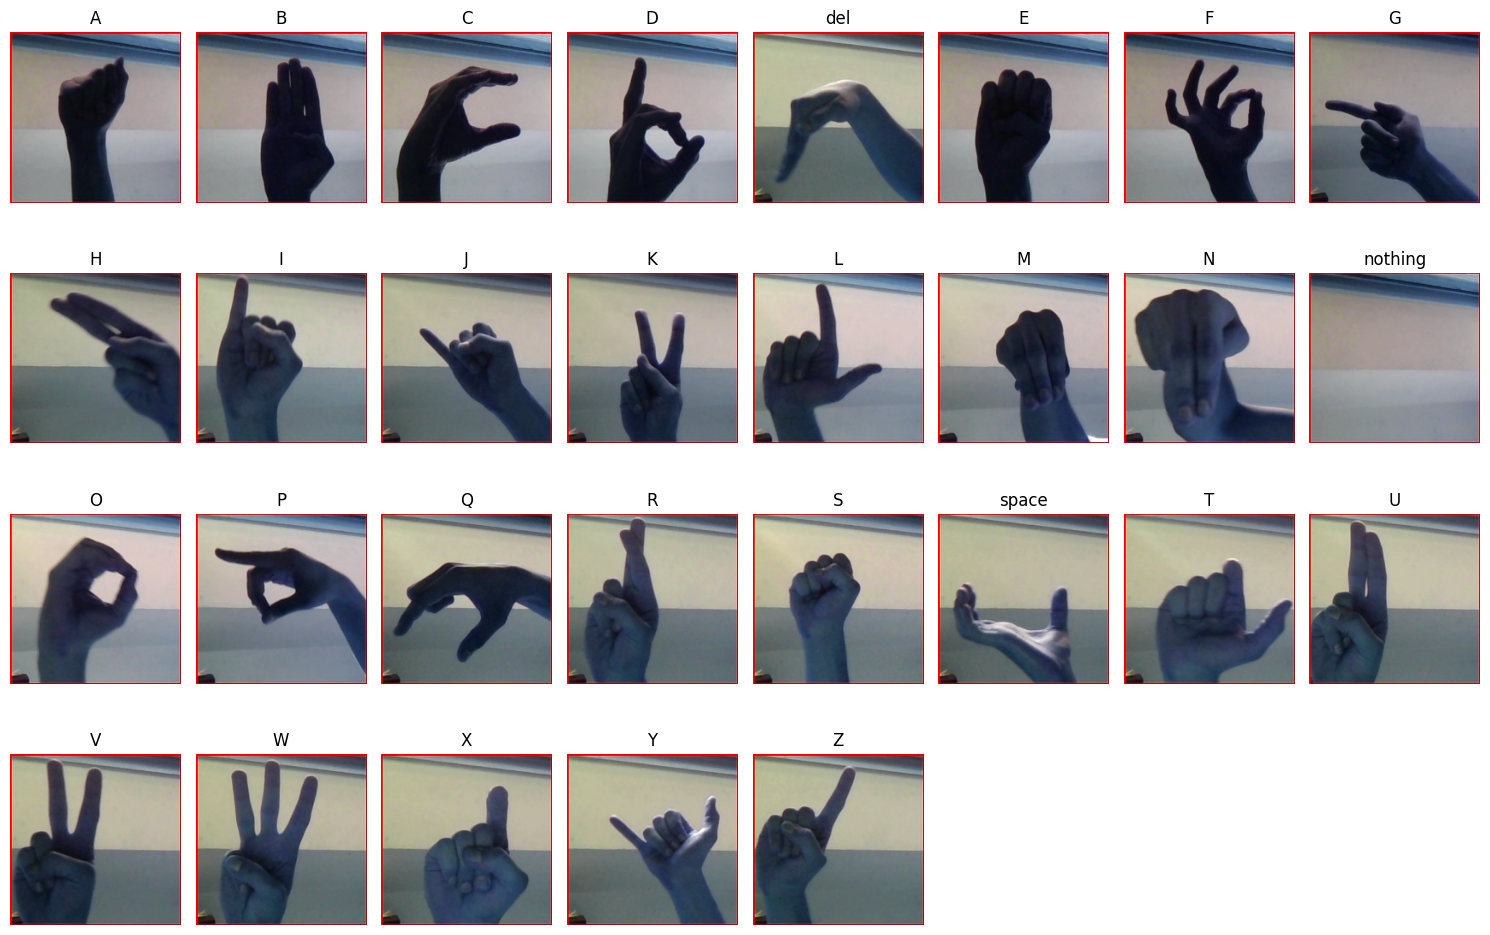

In [26]:
# Get all the labels
labels = train_df['label'].unique() 

# Plot the graph to show images of all the labels
plt.figure(figsize=(15, 10))
for i, label in enumerate(labels):
    label_row = train_df[train_df['label'] == label].iloc[0]
    image_path = label_row['path']

    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, original_size)

    plt.subplot(4, 8, i + 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Processing:

In [27]:
def preprocess_images(size):
    X = []
    y = []

    for _, row in train_df.iterrows():
        img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, size)
        img_normalized = img_resized.astype('float32') / 255.0
        
        X.append(img_normalized)
        y.append(row['label'])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [28]:
X, y = preprocess_images(target_size)

In [29]:
X.shape

(87000, 32, 32)

In [30]:
y

array(['A', 'A', 'A', ..., 'Z', 'Z', 'Z'], dtype='<U7')

# Implementation of ResNet18

In [31]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# Expand channel dimension (Grayscale to 1 channel)
X_train = np.expand_dims(X, axis=1)  # From (N, 32, 32) -> (N, 1, 32, 32)

# Encode labels into numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y)  # Convert labels to integers

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Create TensorDataset and DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [34]:
# X_test = np.expand_dims(X_test, axis=1)  # Assuming you have X_test preprocessed similarly
# y_test_encoded = label_encoder.transform(y_test)

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
import torch.nn as nn
import torchvision.models as models

def create_resnet18(num_classes):
    # Load pre-trained ResNet-18
    model = models.resnet18(pretrained=True)
    
    # Modify the first convolutional layer to accept 1-channel input
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # Modify the fully connected layer to output the correct number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

# Initialize the model
num_classes = 29
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_resnet18(num_classes).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Jerin/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 13.4MB/s]


In [36]:
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [37]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()  # Set the model to training mode
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

In [38]:
train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)

Epoch 1/10, Loss: 0.6918, Accuracy: 0.7719
Epoch 2/10, Loss: 0.1595, Accuracy: 0.9482
Epoch 3/10, Loss: 0.1015, Accuracy: 0.9689
Epoch 4/10, Loss: 0.0791, Accuracy: 0.9755
Epoch 5/10, Loss: 0.0613, Accuracy: 0.9820
Epoch 6/10, Loss: 0.0483, Accuracy: 0.9856
Epoch 7/10, Loss: 0.0381, Accuracy: 0.9889
Epoch 8/10, Loss: 0.0446, Accuracy: 0.9881
Epoch 9/10, Loss: 0.0297, Accuracy: 0.9916
Epoch 10/10, Loss: 0.0270, Accuracy: 0.9925


In [39]:
def preprocess_test_images(test_folder, size=(32, 32)):

    X_test = []
    y_test = []
    
    # Iterate through all files in the test folder
    for file in os.listdir(test_folder):
        if file.endswith('.jpg'):  # Ensure only image files are processed
            label = file.split('_')[0]  # Extract label from filename (e.g., "A_test.jpg" -> "A")
            img_path = os.path.join(test_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize and normalize the image
                img_resized = cv2.resize(img, size)
                img_normalized = img_resized.astype('float32') / 255.0
                X_test.append(img_normalized)
                y_test.append(label)
    
    # Convert lists to NumPy arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_test, y_test

# Path to test dataset
test_folder = os.path.join(base_path, 'asl_alphabet_test')

# Preprocess test images
X_test, y_test = preprocess_test_images(test_folder, size=target_size)

# Verify the shape and labels
print(f"Shape of X_test: {X_test.shape}")
print(f"Unique labels in y_test: {np.unique(y_test)}")

Shape of X_test: (28, 32, 32)
Unique labels in y_test: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'nothing' 'space']


One thing that we do need to note is that, ResNet-18, by default, takes 3-D RGB input. Since our input image was compressed to 1-D earlier, we need to resize it to make it compatible with ResNet-18

In [40]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Expand channel dimension for grayscale images
X_test = np.expand_dims(X_test, axis=1)  # (N, 32, 32) -> (N, 1, 32, 32)

# Convert labels to integers using LabelEncoder from training
y_test_encoded = label_encoder.transform(y_test)

# Convert data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Create DataLoader for testing
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)


In [41]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # Track accuracy
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Collect predictions for metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Generate confusion matrix and classification report
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Classification Report:\n", classification_report(all_labels, all_preds))

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

Test Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00 

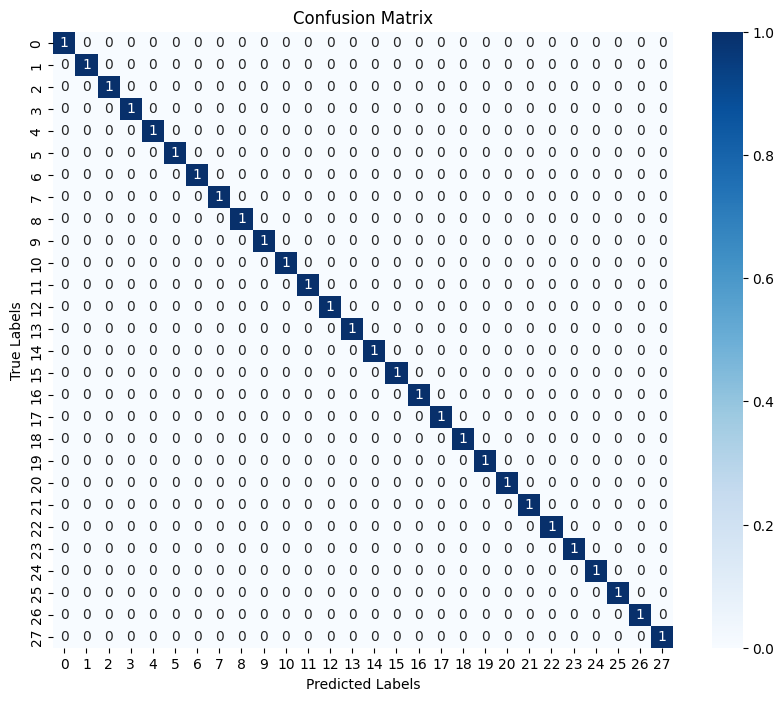

In [42]:
evaluate_model(model, test_loader, device)

As we saw above, the initial training was done on the whole training data without splitting. This meant that ResNet was trained on 87,000 images. Then subsequently tested on the 29 image testing dataset. Although it ended up with testing accuracy at **100%** , this will not provide a conclusive result as the testing dataset is very limited. To mitigate that, we attempted the train-val-test split and retrained the model again. 

Epoch 1/10, Loss: 710.9996, Train Acc: 0.7145, Val Acc: 0.8398
Epoch 2/10, Loss: 200.0356, Train Acc: 0.9185, Val Acc: 0.8522
Epoch 3/10, Loss: 119.9938, Train Acc: 0.9533, Val Acc: 0.9639
Epoch 4/10, Loss: 100.5006, Train Acc: 0.9609, Val Acc: 0.9674
Epoch 5/10, Loss: 75.4289, Train Acc: 0.9712, Val Acc: 0.9313
Epoch 6/10, Loss: 63.7188, Train Acc: 0.9768, Val Acc: 0.9753
Epoch 7/10, Loss: 59.7865, Train Acc: 0.9776, Val Acc: 0.9494
Epoch 8/10, Loss: 42.9165, Train Acc: 0.9843, Val Acc: 0.9910
Epoch 9/10, Loss: 38.4012, Train Acc: 0.9863, Val Acc: 0.9872
Epoch 10/10, Loss: 38.3900, Train Acc: 0.9868, Val Acc: 0.9753
Test Accuracy: 97.40%
Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.99      0.99       600
           B       0.97      1.00      0.99       600
           C       1.00      1.00      1.00       600
           D       0.99      1.00      1.00       600
           E       1.00      0.96      0.98       600
     

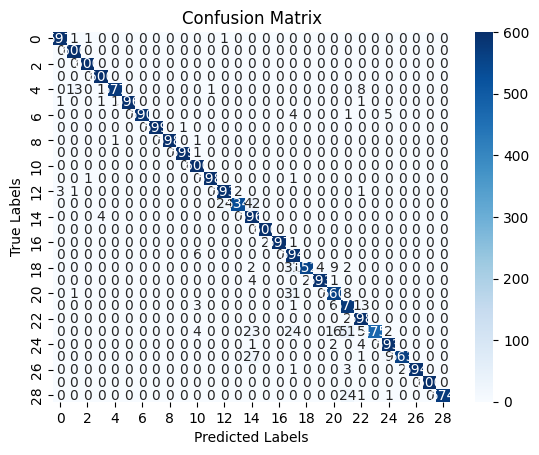

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Preprocessing and Splitting the Data
def split_and_prepare_data(X, y, test_size=0.2, val_size=0.2):
    """
    Split the data into training, validation, and testing datasets.
    """
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  # Convert labels to integers

    # First split into train + validation and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded)

    # Further split train + validation into training and validation
    val_fraction = val_size / (1 - test_size)  # Adjust val size relative to train + validation split
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_fraction, random_state=42, stratify=y_train_val)

    return (X_train, X_val, X_test, y_train, y_val, y_test, label_encoder)

#Convert Data to PyTorch Tensors
def create_dataloaders(X_train, X_val, y_train, y_val, batch_size):
    # Expand dimensions for grayscale images (1 channel)
    X_train = np.expand_dims(X_train, axis=1)  # (N, 32, 32) -> (N, 1, 32, 32)
    X_val = np.expand_dims(X_val, axis=1)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

#Create ResNet-18 Model
def create_resnet18(num_classes):
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify input layer for 1 channel
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify output layer for 29 classes
    return model

#Training ResNet-18
def train_resnet(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):

    model.to(device)
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        #Validation loop
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_accuracies, val_accuracies

#Evaluate the Model
def evaluate_resnet(model, test_loader, device, label_encoder):

    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    #Confusion Matrix and Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
    conf_matrix = confusion_matrix(all_labels, all_preds)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Execution
num_classes = 29
batch_size = 64
num_epochs = 10
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split data
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = split_and_prepare_data(X, y)

# Create dataloaders
train_loader, val_loader = create_dataloaders(X_train, X_val, y_train, y_val, batch_size)

# Initialize and train model
model = create_resnet18(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_accuracies, val_accuracies = train_resnet(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

# Create test loader
X_test = np.expand_dims(X_test, axis=1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Evaluate on test set
evaluate_resnet(model, test_loader, device, label_encoder)


In line with our expectations, we were able to get an overall test accuracy of **97.40%** . This highlights the overly optimistic nature of the earlier testing attempt, as well as the expected performance of ResNet-18 on a very structured, deep and properly pre-processed image dataset. 

References: 
- https://www.geeksforgeeks.org/resnet18-from-scratch-using-pytorch/ 
- https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/
- https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch